In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent, TrainableAgent
from society.simulations.weighted import WeightedNetworkSimulation
from society.strategies.gameplay.constant import AllC, AllD
from society.strategies.gameplay.qlearning import TabularQLearningGameplayStrategy
from society.strategies.gameplay.random import RandomGameplayStrategy
from society.strategies.gameplay.tft import TitForTat
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        Agent(TabularQLearningGameplayStrategy(lookback=3, epsilon=0.1, learning_rate=0.1), i, population)
        for i in range(population)
    ]

    agents[0] = Agent(TitForTat(), 0, population)
    agents[1] = Agent(TitForTat(), 1, population)
    agents[2] = Agent(TitForTat(), 2, population)
    agents[3] = Agent(TitForTat(), 3, population)

    G = nx.connected_caveman_graph(communities, size)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1.0
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

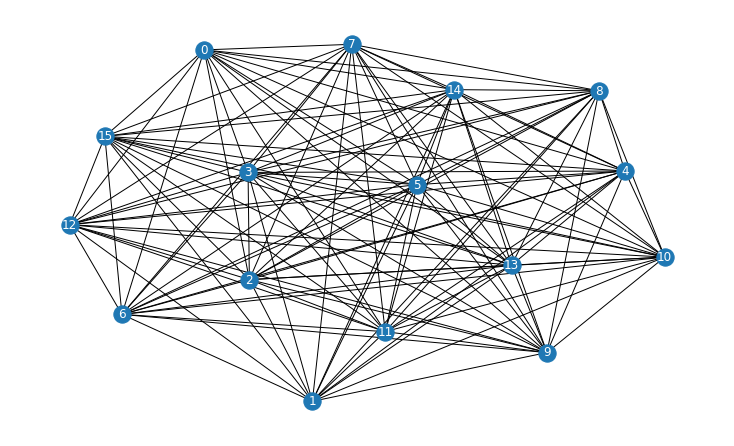

In [3]:
_, _, G = generate_population(1, 16)

nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
def compute_policies(agents):
    policies = [
        agent.gameplay_strategy._q_table.argmax(axis=-1)
        if hasattr(agent.gameplay_strategy, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j, k]]
                for i in range(4)
                for j in range(4)
                for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [5]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

In [6]:
POPULATION = (1, 16)
ROUNDS = 25_000

run_rewards = []
run_cumulative_rewards = []
run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = WeightedNetworkSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    # TODO: maybe I should switch to mean rewards (?)
    # mean_rewards = [(i, np.mean(history)) for i, history in enumerate(sim.reward_histories)]
    # mean_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT: {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT: {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    # for rh in sim.reward_histories:
    #     plt.plot(np.cumsum(rh))
    
    # plt.show()


Run 1:   0%|          | 0/25000 [00:00<?, ?it/s]

BEST AGENT: 152417 (0.8319403343197632, CCDCDCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCDCDCDCCCCCCCCCCCCCCCCCCCCCCC)
WORST AGENT: 141535 (0.9446311509418306, OTHER)


In [7]:
cumulative_rewards[0][0]

10

In [8]:
agents[cumulative_rewards[0][0]].gameplay_strategy._q_table

array([[[[260.04032761, 258.82262949],
         [257.15149703, 163.93087223],
         [241.90862739, 258.27266554],
         [222.09133183,  12.71763699]],

        [[247.73171245, 259.06526582],
         [230.03930586,   4.90721781],
         [216.77368162,  17.16830349],
         [ 55.07894052,   0.        ]],

        [[263.94671801, 229.6457908 ],
         [249.90824889,  65.10627476],
         [259.66231221, 226.59104085],
         [259.25058419, 151.42957737]],

        [[254.46876116, 100.82566201],
         [162.33717858,   0.        ],
         [ 86.9600193 ,   0.5       ],
         [  0.        ,   0.        ]]],


       [[[263.94530147, 240.55859615],
         [206.17283466,   0.        ],
         [244.32124335, 259.30915529],
         [244.74542286,  18.17560344]],

        [[259.30065202,  54.44393496],
         [130.92057309,   0.        ],
         [ 48.20436561,   0.        ],
         [  0.        ,   0.        ]],

        [[244.40416768,  29.55301007],
         [2

In [9]:
from datetime import datetime
import pickle

with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
    pickle.dump({
        "rewards": run_rewards,
        "cumulative_rewards": run_cumulative_rewards,
        # "action_histories": run_action_histories,
        "reward_histories": run_reward_histories,
        "policies": run_policies,
    }, f)


In [10]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()}
mean_cumulative_reward_policies = {policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()}

In [11]:
for policy in sorted(mean_cumulative_reward_policy_ranks, key=lambda x: mean_cumulative_reward_policy_ranks[x]):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

1.0                      CCDCDCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCDCDCDCCCCCCCCCCCCCCCCCCCCCCC
2.0                      CDDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCC
4.0                      CDCCCCCCCCDCCCCCCDCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
5.0                      CDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCDCCDCC
7.0                      CCCCCDDDCCCDCCCCCCCDCCCCCCCDCDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
8.0                      CCCCCCCCCCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCC
9.0                      CCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
10.0                     OTHER
10.0                     CCCDCCCCCCCCCCCCCCCCCCCCDCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCDCCCCC
11.0                     CCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCC
12.5                     CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
14.0                     CCCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCDCCCCCCDCC

In [12]:
for policy in sorted(mean_cumulative_reward_policies, key=lambda x: mean_cumulative_reward_policies[x], reverse=True):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

152417.0                 CCDCDCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCDCDCDCCCCCCCCCCCCCCCCCCCCCCC
148594.0                 CDDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCC
147909.0                 CDCCCCCCCCDCCCCCCDCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
147804.0                 CDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCDCCDCC
145784.0                 CCCCCDDDCCCDCCCCCCCDCCCCCCCDCDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
145784.0                 CCCCCCCCCCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCC
145711.0                 CCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
145416.0                 CCCDCCCCCCCCCCCCCCCCCCCCDCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCDCCCCC
145112.0                 CCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCC
144626.0                 OTHER
144552.0                 CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
143905.0                 CCCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCDCCCCCCDCC

In [13]:
compute_policies([agents[cumulative_rewards[0][0]]])

['CCDCDCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCDCDCDCCCCCCCCCCCCCCCCCCCCCCC']

In [14]:
agents[cumulative_rewards[0][0]].gameplay_strategy._q_table

array([[[[260.04032761, 258.82262949],
         [257.15149703, 163.93087223],
         [241.90862739, 258.27266554],
         [222.09133183,  12.71763699]],

        [[247.73171245, 259.06526582],
         [230.03930586,   4.90721781],
         [216.77368162,  17.16830349],
         [ 55.07894052,   0.        ]],

        [[263.94671801, 229.6457908 ],
         [249.90824889,  65.10627476],
         [259.66231221, 226.59104085],
         [259.25058419, 151.42957737]],

        [[254.46876116, 100.82566201],
         [162.33717858,   0.        ],
         [ 86.9600193 ,   0.5       ],
         [  0.        ,   0.        ]]],


       [[[263.94530147, 240.55859615],
         [206.17283466,   0.        ],
         [244.32124335, 259.30915529],
         [244.74542286,  18.17560344]],

        [[259.30065202,  54.44393496],
         [130.92057309,   0.        ],
         [ 48.20436561,   0.        ],
         [  0.        ,   0.        ]],

        [[244.40416768,  29.55301007],
         [2

In [15]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS, PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)', '(C, C)', '(C, C)') => C
('(C, C)', '(C, C)', '(C, C)', '(C, D)') => C
('(C, C)', '(C, C)', '(C, C)', '(D, C)') => D
('(C, C)', '(C, C)', '(C, C)', '(D, D)') => C
('(C, C)', '(C, C)', '(C, D)', '(C, C)') => D
('(C, C)', '(C, C)', '(C, D)', '(C, D)') => C
('(C, C)', '(C, C)', '(C, D)', '(D, C)') => C
('(C, C)', '(C, C)', '(C, D)', '(D, D)') => C
('(C, C)', '(C, C)', '(D, C)', '(C, C)') => C
('(C, C)', '(C, C)', '(D, C)', '(C, D)') => C
('(C, C)', '(C, C)', '(D, C)', '(D, C)') => C
('(C, C)', '(C, C)', '(D, C)', '(D, D)') => C
('(C, C)', '(C, C)', '(D, D)', '(C, C)') => C
('(C, C)', '(C, C)', '(D, D)', '(C, D)') => C
('(C, C)', '(C, C)', '(D, D)', '(D, C)') => C
('(C, C)', '(C, C)', '(D, D)', '(D, D)') => C
('(C, C)', '(C, D)', '(C, C)', '(C, C)') => C
('(C, C)', '(C, D)', '(C, C)', '(C, D)') => C
('(C, C)', '(C, D)', '(C, C)', '(D, C)') => D
('(C, C)', '(C, D)', '(C, C)', '(D, D)') => C
('(C, C)', '(C, D)', '(C, D)', '(C, C)') => C
('(C, C)', '(C, D)', '(C, D)', '(C